In [1]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

c:\Users\jcrl\miniconda3\envs\ModelML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/data_pre.csv")


In [3]:
df = df.drop(["Unnamed: 0"], axis=1)

In [4]:
df["DEP_TIME"] = pd.to_datetime(df["DEP_TIME"]).dt.hour

In [5]:
df["FL_DATE"]=pd.to_datetime(df["FL_DATE"]).dt.dayofyear

In [6]:
X = df.drop(["DEP_DELAY"], axis=1)
print(X.shape)
X = X.to_numpy()


y = df["DEP_DELAY"].values

(54180, 15)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std

X_test_mean = X_test.mean(axis=0)
X_test_std = X_test.std(axis=0)
X_test = (X_test - X_test_mean) / X_test_std

# standardize target
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std

y_test_mean = y_test.mean()
y_test_std = y_test.std()
y_test = (y_test - y_test_mean) / y_test_std


In [8]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [9]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)




corr, mae, rae, rmse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.011
MAE: 3533056383.960
RMSE: 5206834839.693
R2: 0.000


In [10]:
def model(X, obs=None):
    
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [11]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train).float()
y_train_small = torch.tensor(y_train).float()

In [12]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [13:27,  1.49it/s, step size=7.33e-03, acc. prob=0.928]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.00     -0.00     -0.01      0.01   1298.99      1.00
   beta[0]     -0.00      0.02     -0.01     -0.04      0.03    282.69      1.00
   beta[1]      0.23      0.01      0.23      0.22      0.24    815.78      1.01
   beta[2]      0.12      0.01      0.12      0.11      0.12   1012.76      1.00
   beta[3]     -0.04      0.02     -0.04     -0.07     -0.01    297.68      1.00
   beta[4]     -0.14      0.01     -0.14     -0.15     -0.13    641.57      1.00
   beta[5]      0.06      0.35      0.08     -0.50      0.65    131.71      1.00
   beta[6]     -0.00      0.45      0.03     -0.71      0.76    132.04      1.00
   beta[7]     -0.00      0.08      0.00     -0.13      0.12    132.05      1.00
   beta[8]     -0.01      0.31      0.02     -0.49      0.51    131.89      1.00
   beta[9]      0.01      0.10      0.01     -0.16      0.16    132.51      1.00
  beta[10]      0.01      0

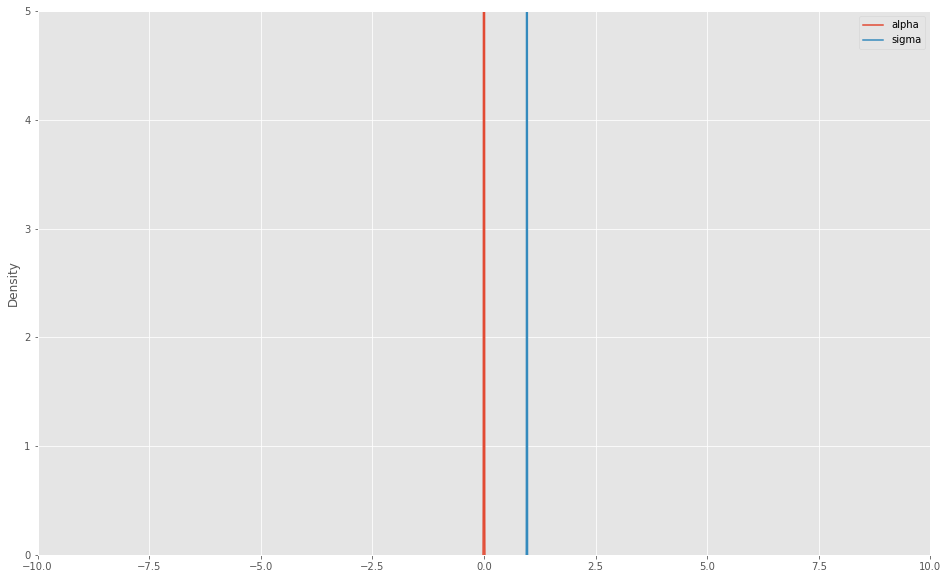

In [13]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.distplot(posterior_samples["alpha"])
sns.distplot(posterior_samples["sigma"])

# Alternate plotting due to deprecated distplot-function
#sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
#sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-10,10,0,5])
plt.show()

In [14]:
print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

torch.Size([1000])
torch.Size([1000, 15])


In [15]:
# Convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.288
MAE: 21.035
RMSE: 36.341
R2: 0.083


Pyro: Train on full dataset using Stochastic Variational Inference (SVI)

In [16]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [17]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [18]:
# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [19]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 86305.1
[100] ELBO: 76732.0
[200] ELBO: 79898.0
[300] ELBO: 74488.2
[400] ELBO: 67177.9
[500] ELBO: 66549.2
[600] ELBO: 62835.6
[700] ELBO: 63214.6
[800] ELBO: 59650.1
[900] ELBO: 57358.6
[1000] ELBO: 56180.7
[1100] ELBO: 52768.4
[1200] ELBO: 53149.4
[1300] ELBO: 51610.5
[1400] ELBO: 51071.4
[1500] ELBO: 50991.1
[1600] ELBO: 50750.3
[1700] ELBO: 50726.0
[1800] ELBO: 50476.3
[1900] ELBO: 50437.2
[2000] ELBO: 50776.4
[2100] ELBO: 50400.8
[2200] ELBO: 50890.6
[2300] ELBO: 50600.8
[2400] ELBO: 50429.0
[2500] ELBO: 50298.5
[2600] ELBO: 50218.2
[2700] ELBO: 50174.2
[2800] ELBO: 50223.0
[2900] ELBO: 50201.9
[3000] ELBO: 50185.4
[3100] ELBO: 50186.7
[3200] ELBO: 50193.9
[3300] ELBO: 50205.4
[3400] ELBO: 50200.2
[3500] ELBO: 50213.9
[3600] ELBO: 50233.5
[3700] ELBO: 50218.8
[3800] ELBO: 50234.2
[3900] ELBO: 50179.1


In [20]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [21]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# Convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.287
MAE: 21.040
RMSE: 36.350
R2: 0.082


2.3 Pyro: Heteroscedastic regression

In [22]:
def heteroscedastic_model(X, obs=None):
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))                 # Prior for the bias/intercept of the mean
    beta_mu  = pyro.sample("beta_mu", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the mean
    alpha_v = pyro.sample("alpha_v", dist.Normal(0., 1.))                   # Prior for the bias/intercept of the variance
    beta_v  = pyro.sample("beta_v", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha_mu + X.matmul(beta_mu), torch.exp(alpha_v + X.matmul(beta_v))), obs=obs)
        
    return y

In [23]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [24]:
# Define guide function
guide = AutoMultivariateNormal(heteroscedastic_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 8000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(heteroscedastic_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 200 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 97512043.5
[200] ELBO: 3020309.9
[400] ELBO: 116975.6
[600] ELBO: 70006.9
[800] ELBO: 55430.0
[1000] ELBO: 50924.9
[1200] ELBO: 49800.2
[1400] ELBO: 50331.6
[1600] ELBO: 48725.2
[1800] ELBO: 49302.9
[2000] ELBO: 48187.6
[2200] ELBO: 48813.5
[2400] ELBO: 48057.3
[2600] ELBO: 47839.2
[2800] ELBO: 47807.4
[3000] ELBO: 47632.9
[3200] ELBO: 47711.6
[3400] ELBO: 47645.5
[3600] ELBO: 47347.1
[3800] ELBO: 47409.3
[4000] ELBO: 47324.5
[4200] ELBO: 47420.4
[4400] ELBO: 47300.1
[4600] ELBO: 47341.3
[4800] ELBO: 47343.3
[5000] ELBO: 47325.4
[5200] ELBO: 47268.7
[5400] ELBO: 47300.8
[5600] ELBO: 47264.7
[5800] ELBO: 47254.8
[6000] ELBO: 47287.5
[6200] ELBO: 47277.6
[6400] ELBO: 47261.8
[6600] ELBO: 47254.3
[6800] ELBO: 47255.4
[7000] ELBO: 47250.8
[7200] ELBO: 47265.5
[7400] ELBO: 47269.0
[7600] ELBO: 47243.3
[7800] ELBO: 47256.8


In [25]:
from pyro.infer import Predictive

predictive = Predictive(heteroscedastic_model, guide=guide, num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha_v", "beta_v"))
samples = predictive(X_train_torch, y_train_torch)

In [27]:
alpha_samples = samples["alpha_mu"].detach().numpy()
beta_samples = samples["beta_mu"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.286
MAE: 20.971
RMSE: 36.477
R2: 0.076


In [28]:
alpha_v_samples = samples["alpha_v"].detach().numpy()
beta_v_samples = samples["beta_v"].detach().numpy()
sigma_hat = np.mean(np.exp(alpha_v_samples.T + np.dot(X_test, beta_v_samples[:,0].T)), axis=1)

In [29]:
np.set_printoptions(precision=3)
print(sigma_hat[:10])

[0.743 0.54  0.925 0.619 0.889 0.594 0.825 1.213 0.763 0.946]
